# Class Library

In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

# New import for progress bars
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.cluster import KMeans

# LLM-related imports
import google.generativeai as genai
from openai import OpenAI
from together import Together

c:\Users\Chris\anaconda3\envs\bertopic_39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %run 00_lib_preprocessing.ipynb
# %run 00_lib_sqlwriter.ipynb

# # Download NLTK packages
# nltk.download('punkt')
# nltk.download('stopwords')  # Just in case stopwords are needed
# nltk.download('wordnet')  # For lemmatization support

In [3]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
class DataIngestion:
    """
    Class responsible for reading data files and performing initial data cleaning.
    """
    def __init__(self, file_path:str):
        self.file_path = file_path

    def load_data(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Loads the archives, articles, and contents DataFrames from data files.
        """
        print("[INFO] Loading data files...")
        df = pd.read_excel(self.file_path)

        return df

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
class BERTopicModeler:
    """
    Wrapper class for the BERTopic pipeline.
    """
    def __init__(self, embedding_model_name: str, max_features: int = None):
        """
        Initializes the BERTopic pipeline with SentenceTransformer, TF-IDF, and HDBSCAN.
        """
        self.embedding_model = SentenceTransformer(embedding_model_name)
        
        self.umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.1, metric='cosine', random_state=42)
        
        self.kmeans_model = KMeans(n_clusters=35, init="k-means++", n_init=1, random_state=42)  # KMeans(n_clusters=35, random_state=42) # force outliers into cluster
        
        self.hdbscan_model = HDBSCAN(
            min_cluster_size=3,
            min_samples=None,
            metric='euclidean',
            cluster_selection_epsilon=0.0,
            cluster_selection_method='eom',
            prediction_data=True
        )

        self.vectorizer_model = TfidfVectorizer(
            stop_words="english", # or None
            max_features=max_features,
            ngram_range=(1, 3),
            tokenizer=LemmaTokenizer()
        )

        self.ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
        # Enable verbose to get some internal logs from BERTopic
        self.topic_model = BERTopic(
            embedding_model=self.embedding_model,
            umap_model=self.umap_model,
            hdbscan_model=self.hdbscan_model,
            vectorizer_model=self.vectorizer_model,
            ctfidf_model=self.ctfidf_model,
            nr_topics="auto", # None, no reduction. "auto" will reduce topics using HDBSCAN
            top_n_words=10,
            verbose=True  # <--- Will print messages during training
        )

    def fit_transform(self, texts: list[str]) -> tuple[list[int], list[list[float]]]:
        """
        Fits the topic model, and returns the assigned topic labels and probabilities.
        """
        print("[INFO] Fitting BERTopic model... This may take a while.")
        topics, probs = self.topic_model.fit_transform(texts)
        print("[INFO] BERTopic fitting complete.")
        return topics, probs

    def reduce_topics(self, texts: list[str], probabilities, nr_topics: int = 20):
        """
        Reduces the number of topics to nr_topics.
        """
        print(f"[INFO] Reducing number of topics to {nr_topics}...")
        self.topic_model.reduce_topics(texts, probabilities, nr_topics=nr_topics)

    def get_topic_info(self) -> pd.DataFrame:
        """
        Returns topic information (id, count, representative words).
        """
        return self.topic_model.get_topic_info()

# ------------------------------------------------------------------
# Abstract base class for LLM usage
# ------------------------------------------------------------------

class BaseLLMClient:
    """
    Abstract base class for Large Language Model (LLM) clients.
    """
    def __init__(self, config_path: str):
        with open(config_path, 'r', encoding='utf-8') as file:
            self.config = json.load(file)

    def generate_semantic_topic(self, topic_name: str, top_keywords: str) -> str:
        """
        Method to be implemented in subclasses to generate a semantic topic.
        """
        raise NotImplementedError("Subclasses must implement this method.")


# ------------------------------------------------------------------
# Concrete LLM Clients
# ------------------------------------------------------------------

class GoogleAISemanticTopicClient(BaseLLMClient):
    """
    LLM client for Google Generative AI.
    """
    def generate_semantic_topic(self, topic_name: str, top_keywords: str) -> str:
        genai.configure(api_key=self.config["google_api_key"])
        model = genai.GenerativeModel("gemma-2-2b-it")
        input_text = f"{topic_name}, {top_keywords}"
        prompt = (
            f"Create semantic topics (max 10 words) "
            f"from the following keywords: {input_text}"
        )
        response = model.generate_content(prompt)
        return response.text


class OpenAISemanticTopicClient(BaseLLMClient):
    """
    LLM client for OpenAI (proxied via a custom base_url).
    """
    def generate_semantic_topic(self, input_text: str) -> str:
        prompt = (
            "Create a short semantic topic label (no more than 3 words) "
            f"from the following text: {input_text}"
        )

        response = self.client.chat.completions.create(
            model="deepseek-ai/DeepSeek-R1",
            messages=[
                {"role": "system", "content": "You are a concise, helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=1000,
            temperature=0.7,
            top_p=0.7,
            top_k=50,
            repetition_penalty=1,
            stop=["<|end_of_sentence|>"],
            stream=True
        )

        semantic_topic = ""
        for token in response:
            if hasattr(token, 'choices') and token.choices:
                semantic_topic += token.choices[0].delta.content

        return semantic_topic


class TogetherAISemanticTopicClient(BaseLLMClient):
    """
    LLM client for the Together API.
    """
    def __init__(self, config_path: str):
        super().__init__(config_path)
        os.environ["TOGETHER_API_KEY"] = self.config["together_api_key"]
        self.client = Together(api_key=self.config["together_api_key"])

    def generate_semantic_topic(self, topic_name: str, top_keywords: str, max_num_of_output_words:int = 3) -> str:
        """
        Generates a concise semantic topic label from the topic name and keywords.
        """

        # Turn list of keywords into a short string:
        keywords_text = top_keywords

        # Create a clear, direct instruction for the LLM:
        prompt = f"""
            You are an expert in Internet and technologies domain and topic modeling.
            Your task: Create a high level research theme (<={max_num_of_output_words} words) that represents these keywords.

            Topic Name: {topic_name}
            Representative Keywords: {keywords_text}

            Constraints:
            1. ONLY output the research theme label itself - no explanations or additional text
            2. Maximum {max_num_of_output_words} words
            3. Must identify a theme that is coherent with the keywords collection
            4. Use terminology appropriate for academic knowledge organization
            """

        response = self.client.chat.completions.create(
            model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
            messages=[
                {"role": "system", "content": "You are a precise topic labeling assistant that generates only the requested label with no additional text."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=100, # short label
            temperature=0.1, # to prioritize precision instead of creativity
            top_p=0.9, # allow some variety but still maintaining focus
            top_k=40,
            repetition_penalty=1.1, # prevent repetitive output
            stop=["\n", "."], # stop tokens
            stream=True
        )

        semantic_topic = ""
        for token in response:
            if hasattr(token, 'choices') and token.choices:
                semantic_topic += token.choices[0].delta.content

        # Cleanup: strip any leading/trailing whitespace/newlines:
        return semantic_topic.strip()


# ------------------------------------------------------------------
# DataFrame Processor for applying semantic topic generation
# ------------------------------------------------------------------

class SemanticTopicDataFrameProcessor:
    @staticmethod
    def add_semantic_topic_column(
        df: pd.DataFrame,
        semantic_topic_generator: BaseLLMClient,
        name_col: str = 'Name',
        representation_col: str = 'Representation',
        output_col: str = 'Semantic_Topic', 
        max_num_of_output_words  = 3
    ) -> pd.DataFrame:
        """
        Use an LLM client to create a semantic topic for each row, then store the result in new column.

        :param df: DataFrame containing columns for name_col and representation_col
        :param semantic_topic_generator: An instance of a BaseLLMClient subclass
        :param name_col: Column name that has a descriptive 'Name'
        :param representation_col: Column name that has text to be summarized or used for generation
        :param output_col: Name of the new column for storing the generated semantic topic
        :return: DataFrame with the new semantic topic column.
        """

        # --- Option A: A progress bar via a for-loop ---
        # Initialize an empty list to collect results
        results = []
        print("[INFO] Generating semantic topics with LLM (this may take a while).")
        for idx in tqdm(range(len(df)), desc="LLM Generation"):
            row = df.iloc[idx]
            topic_name = row[name_col]
            topic_keywords = row[representation_col]
            topic = semantic_topic_generator.generate_semantic_topic(topic_name, topic_keywords,max_num_of_output_words) 
            results.append(topic)

        df[output_col] = results

        return df


import json
import pandas as pd

class DataFrameExporter:
    """
    Class responsible for exporting a DataFrame to CSV or excel.    
    """
    def __init__(self, config_path: str):
        with open(config_path, "r", encoding="utf-8") as f:
            self.config = json.load(f)

    def export_to_excel(self, df: pd.DataFrame, param_name:str) -> None:
        """
        Reads the 'topic_modeling_output_excel_filename' from the config,
        then writes the DataFrame to that excel file.
        """
        output_file = self.config.get(param_name, "default_output.xlsx")
        df.to_excel(output_file, index=False)
        print(f"[INFO] Successfully exported DataFrame to {output_file}")

## Start Processing

In [5]:
# ------------------------------------------------------------------
# Main usage (end-to-end pipeline)
# ------------------------------------------------------------------

# STEP 1: Load data
topics_over_time_df = pd.read_excel('results/topics_over_time.xlsx')
display(topics_over_time_df.head())
display (topics_over_time_df.shape)

topics_info_df = pd.read_excel('results/topic_info_df_gist_kmeans.xlsx')
display(topics_info_df.head())
display (topics_info_df.shape)


,Topic,Words,Frequency,Timestamp,Semantic_Topic,Name
0,1,"internet-based research, subject ., researcher...",1,1995-12-21 08:19:40.800,1 Digital Inequality Among Older Adults,1 Digital Inequality Among Older Adults
1,3,"cgi, perl, , cgi, cgi ,, perl ,",3,1995-12-21 08:19:40.800,3 Public Library Services and Community Engage...,3 Public Library Services and Community Engage...
2,4,"amv, amv scene, fan production, scene, . reward",3,1995-12-21 08:19:40.800,4 Transmedia Fan Fiction and Personal Branding...,4 Transmedia Fan Fiction and Personal Branding...
3,5,"cash, digital cash, electronic cash, cash , el...",3,1995-12-21 08:19:40.800,5 Digital Currencies and Electronic Payment Sy...,5 Digital Currencies and Electronic Payment Sy...
4,6,"kid ,, kid, book review, child , internet, 's ...",1,1995-12-21 08:19:40.800,6 Distance Education and Open Educational Reso...,6 Distance Education and Open Educational Reso...


(844, 6)

,Topic,Count,Name,CustomName,Representation,Representative_Docs,Document_%,Semantic_Topic
0,0,87,0_open source_floss_linux_source software,"open source, floss, linux, source software, op...","['open source', 'floss', 'linux', 'source soft...",[' starting with eric raymond\'s groundbreakin...,3.61,0 Open Source Software Development and Free Li...
1,1,34,1_digital skill_elderly_digital inequality_skill,"digital skill, elderly, digital inequality, sk...","['digital skill', 'elderly', 'digital inequali...",['the creative industries workforce requires e...,1.41,1 Digital Inequality Among Older Adults
2,2,95,2_bot_qanon_troll_election,"bot, qanon, troll, election, disinformation, d...","['bot', 'qanon', 'troll', 'election', 'disinfo...",['an internet troll is a person who deliberate...,3.94,2 Social Media Disinformation Detection and Bo...
3,3,49,3_public library_library_public_patron,"public library, library, public, patron, libra...","['public library', 'library', 'public', 'patro...",[' this article presents findings from the pub...,2.03,3 Public Library Services and Community Engage...
4,4,64,4_transmedia_fan_fiction_street art,"transmedia, fan, fiction, street art, photo, i...","['transmedia', 'fan', 'fiction', 'street art',...",['the covid- pandemic accelerated the importan...,2.65,4 Transmedia Fan Fiction and Personal Branding...


(35, 8)

In [6]:
# Function to plot the Elbow Method and Silhouette Scores
def find_optimal_k(X, max_k=10):
    inertia = []
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # # Plot the Elbow Method
    # plt.figure(figsize=(10, 6))
    # plt.subplot(1, 2, 1)
    # plt.plot(range(2, max_k + 1), inertia, marker='o')
    # plt.title('Elbow Method')
    # plt.xlabel('Number of Clusters')
    # plt.ylabel('Inertia')
    
    # # Plot the Silhouette Scores
    # plt.subplot(1, 2, 2)
    # plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    # plt.title('Silhouette Scores')
    # plt.xlabel('Number of Clusters')
    # plt.ylabel('Silhouette Score')
    
    # plt.tight_layout()
    # plt.show()
    
    # Calculate the change in inertia to find the "elbow"
    inertia_diff = np.diff(inertia)
    inertia_diff_2 = np.diff(inertia_diff)
    
    # The elbow point is where the second derivative (change in inertia_diff) is highest
    elbow_point = np.argmax(inertia_diff_2) + 2  # Adding 2 because np.diff reduces the array size by 1
    
    return elbow_point

In [7]:
# STEP 2: Cluster topics based on similarities of keywords to identify themes

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Load the dataset
df = topics_info_df
display(df.head())

# Use TF-IDF Vectorizer to convert text to feature vectors
vectorizer = TfidfVectorizer(max_features=None, stop_words='english')
X = vectorizer.fit_transform(df['Representation'])

# Get number of clusters
num_clusters = find_optimal_k(X, max_k=34)
# num_clusters = 10
print('num_clusters', num_clusters)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Display the cluster centers and their terms
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
cluster_terms = []

for i in range(num_clusters):
    cluster_terms.append([terms[ind] for ind in order_centroids[i, :10]])  # Top 10 terms per cluster

# Show the top terms for each cluster
for i, terms in enumerate(cluster_terms):
    print(f"Cluster {i}: {', '.join(terms)}")

# Add cluster terms to the DataFrame to understand topics in each cluster
df['Cluster_Terms'] = df['Cluster'].map(lambda x: cluster_terms[x])

# Display the resulting DataFrame with clusters and top terms for each cluster
# df[['Topic', 'Count', 'Name', 'Cluster', 'Cluster_Terms']]

# display(df)
topics_info_df = df

,Topic,Count,Name,CustomName,Representation,Representative_Docs,Document_%,Semantic_Topic
0,0,87,0_open source_floss_linux_source software,"open source, floss, linux, source software, op...","['open source', 'floss', 'linux', 'source soft...",[' starting with eric raymond\'s groundbreakin...,3.61,0 Open Source Software Development and Free Li...
1,1,34,1_digital skill_elderly_digital inequality_skill,"digital skill, elderly, digital inequality, sk...","['digital skill', 'elderly', 'digital inequali...",['the creative industries workforce requires e...,1.41,1 Digital Inequality Among Older Adults
2,2,95,2_bot_qanon_troll_election,"bot, qanon, troll, election, disinformation, d...","['bot', 'qanon', 'troll', 'election', 'disinfo...",['an internet troll is a person who deliberate...,3.94,2 Social Media Disinformation Detection and Bo...
3,3,49,3_public library_library_public_patron,"public library, library, public, patron, libra...","['public library', 'library', 'public', 'patro...",[' this article presents findings from the pub...,2.03,3 Public Library Services and Community Engage...
4,4,64,4_transmedia_fan_fiction_street art,"transmedia, fan, fiction, street art, photo, i...","['transmedia', 'fan', 'fiction', 'street art',...",['the covid- pandemic accelerated the importan...,2.65,4 Transmedia Fan Fiction and Personal Branding...


num_clusters 14
Cluster 0: network, instagram, branding, art, instapoetry, photo, fan, fiction, movie, street
Cluster 1: library, digital, museum, collection, public, inequality, skill, community, metadata, preservation
Cluster 2: caf, phone, resident, use, non, based, survey, academic, university, faculty
Cluster 3: medium, political, social, participation, politician, twitter, change, climate, hashtag, protest
Cluster 4: internet, hiv, queer, authoritarian, censorship, computing, sustainability, surplus, broadband, asn
Cluster 5: urban, printing, big, visualization, space, screen, data, citizen, science, gig
Cluster 6: privacy, game, video, virtual, player, modding, modders, mod, gaming, multiplayer
Cluster 7: money, purse, rural, nation, electronic, divide, cryptocurrencies, bank, payment, blockchain
Cluster 8: access, publishing, scholarly, open, journal, monograph, publisher, oa, education, educational
Cluster 9: wikipedia, trust, ai, learning, economy, gift, distance, education, 

In [8]:
# STEP 3: Identify themes
theme_df = topics_info_df[['Cluster','Cluster_Terms','Representation','Count']]
theme_df = theme_df.rename(columns={
    'Representation': 'Cluster_Representation',
    'Count': 'Cluster_Count'
})

# Convert 'Cluster_Terms' and 'Representation' columns from lists to strings
theme_df['Cluster_Terms'] = theme_df['Cluster_Terms'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
theme_df['Cluster_Representation'] = theme_df['Cluster_Representation'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))

# Group by 'Cluster' and aggregate 'Representation'
theme_df = theme_df.groupby(['Cluster', 'Cluster_Terms']).agg({
    'Cluster_Representation': lambda reps: ', '.join(reps),
    'Cluster_Count': 'sum'
}).reset_index()

# Calculate the total count of all clusters
total_count = theme_df['Cluster_Count'].sum()

# Add the 'Cluster_%' column as the percentage of each cluster relative to the total count
theme_df['Cluster_%'] = theme_df['Cluster_Count'] / total_count * 100

# Optional: round the percentage values to two decimal places
theme_df['Cluster_%'] = theme_df['Cluster_%'].round(2)

# Verify the cleaned DataFrame
display(theme_df)
theme_df.to_excel('results/themes_info.xlsx', index=False)

,Cluster,Cluster_Terms,Cluster_Representation,Cluster_Count,Cluster_%
0,0,"network, instagram, branding, art, instapoetry...","['transmedia', 'fan', 'fiction', 'street art',...",140,5.80
1,1,"library, digital, museum, collection, public, ...","['digital skill', 'elderly', 'digital inequali...",206,8.54
2,2,"caf, phone, resident, use, non, based, survey,...","['student', 'academic', 'university', 'faculty...",101,4.19
3,3,"medium, political, social, participation, poli...","['twitter', 'tweet', 'political', 'social medi...",215,8.91
4,4,"internet, hiv, queer, authoritarian, censorshi...","['queer', 'shame', 'hiv', 'woman', 'gender', '...",333,13.80
5,5,"urban, printing, big, visualization, space, sc...","['urban', 'city', 'screen', 'urban screen', 'f...",97,4.02
6,6,"privacy, game, video, virtual, player, modding...","['game', 'virtual world', 'video game', 'gamin...",122,5.06
7,7,"money, purse, rural, nation, electronic, divid...","['e-money', 'blockchain', 'bank', 'cash', 'cry...",119,4.93
8,8,"access, publishing, scholarly, open, journal, ...","['journal', 'publishing', 'open access', 'scho...",106,4.39
9,9,"wikipedia, trust, ai, learning, economy, gift,...","['education', 'learning', 'distance education'...",329,13.63


In [9]:
# # STEP 3.1: Clean keywords for LLM input i.e. remove duplicate, lemmatize, remove special characters, etc.
# import pandas as pd
# import ast
# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
# import re
# import string


# df = theme_df

# # Function to flatten all levels of nested lists
# def flatten_nested_list(nested_list):
#     # Ensure it is a list before attempting to flatten
#     flat_list = []
#     if isinstance(nested_list, list):
#         for item in nested_list:
#                 flat_list.append(item)
#     else:
#         return nested_list  # Return as-is if it's not a list
#     return flat_list

# # Apply the recursive flattening function to the DataFrame column
# df['Cluster_Representation_Clean'] = df['Cluster_Representation'].apply(flatten_nested_list)

# # Display the updated DataFrame
# display(df)

# df.to_excel('results/df.xlsx', index=False)
# # display(theme_df)

In [10]:
# STEP 4: Choose an LLM client for semantic topic generation (example: Together)
llm_client = TogetherAISemanticTopicClient("config/config.json")

theme_df ['Cluster_Terms_Representation'] = theme_df['Cluster_Terms'] + ' ' + theme_df['Cluster_Representation']

# STEP 5: Add semantic topics to the topic_info_df
theme_df = SemanticTopicDataFrameProcessor.add_semantic_topic_column(
    df=theme_df,
    semantic_topic_generator=llm_client,
    name_col="Cluster",
    representation_col="Cluster_Terms_Representation",
    output_col="Semantic_Theme"
)

display(theme_df)
theme_df.to_excel('results/themes_info.xlsx', index=False)

[INFO] Generating semantic topics with LLM (this may take a while).


LLM Generation: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it]


,Cluster,Cluster_Terms,Cluster_Representation,Cluster_Count,Cluster_%,Cluster_Terms_Representation,Semantic_Theme
0,0,"network, instagram, branding, art, instapoetry...","['transmedia', 'fan', 'fiction', 'street art',...",140,5.80,"network, instagram, branding, art, instapoetry...",Digital Media Culture
1,1,"library, digital, museum, collection, public, ...","['digital skill', 'elderly', 'digital inequali...",206,8.54,"library, digital, museum, collection, public, ...",Digital Inequality Research
2,2,"caf, phone, resident, use, non, based, survey,...","['student', 'academic', 'university', 'faculty...",101,4.19,"caf, phone, resident, use, non, based, survey,...",Digital Divide Research
3,3,"medium, political, social, participation, poli...","['twitter', 'tweet', 'political', 'social medi...",215,8.91,"medium, political, social, participation, poli...",Social Media Politics
4,4,"internet, hiv, queer, authoritarian, censorshi...","['queer', 'shame', 'hiv', 'woman', 'gender', '...",333,13.80,"internet, hiv, queer, authoritarian, censorshi...",Digital Governance Studies
5,5,"urban, printing, big, visualization, space, sc...","['urban', 'city', 'screen', 'urban screen', 'f...",97,4.02,"urban, printing, big, visualization, space, sc...",Urban Data Visualization
6,6,"privacy, game, video, virtual, player, modding...","['game', 'virtual world', 'video game', 'gamin...",122,5.06,"privacy, game, video, virtual, player, modding...",Virtual Gaming Privacy
7,7,"money, purse, rural, nation, electronic, divid...","['e-money', 'blockchain', 'bank', 'cash', 'cry...",119,4.93,"money, purse, rural, nation, electronic, divid...",Digital Financial Inclusion
8,8,"access, publishing, scholarly, open, journal, ...","['journal', 'publishing', 'open access', 'scho...",106,4.39,"access, publishing, scholarly, open, journal, ...",Open Access Publishing
9,9,"wikipedia, trust, ai, learning, economy, gift,...","['education', 'learning', 'distance education'...",329,13.63,"wikipedia, trust, ai, learning, economy, gift,...",Technology Enhanced Education


In [11]:
# STEP 5: Merged Topics, Clusters with Over Time data
df_topic = topics_info_df
df_topic = df_topic.drop(['Cluster_Terms', 'Name', 'Representation', 'Representative_Docs', 'Document_%'], axis=1)

df_theme= theme_df
df_theme = df_theme.drop(['Cluster_Terms', 'Cluster_Representation', 'Cluster_Count', 'Cluster_%'], axis=1)

df_topic_theme = pd.merge(df_topic, df_theme, on="Cluster", how="left")
display(df_topic_theme.head(2))

,Topic,Count,CustomName,Semantic_Topic,Cluster,Cluster_Terms_Representation,Semantic_Theme
0,0,87,"open source, floss, linux, source software, op...",0 Open Source Software Development and Free Li...,13,"software, open, source, free, oic, content, pa...",Open Source Software
1,1,34,"digital skill, elderly, digital inequality, sk...",1 Digital Inequality Among Older Adults,1,"library, digital, museum, collection, public, ...",Digital Inequality Research


In [12]:
df_topic_over_time = topics_over_time_df
df_topic_over_time = df_topic_over_time.drop(['Semantic_Topic','Name'], axis=1)

df_themes_over_time = pd.merge(df_topic_over_time, df_topic_theme, on="Topic", how="left")
display(df_themes_over_time.head())

,Topic,Words,Frequency,Timestamp,Count,CustomName,Semantic_Topic,Cluster,Cluster_Terms_Representation,Semantic_Theme
0,1,"internet-based research, subject ., researcher...",1,1995-12-21 08:19:40.800,34,"digital skill, elderly, digital inequality, sk...",1 Digital Inequality Among Older Adults,1,"library, digital, museum, collection, public, ...",Digital Inequality Research
1,3,"cgi, perl, , cgi, cgi ,, perl ,",3,1995-12-21 08:19:40.800,49,"public library, library, public, patron, libra...",3 Public Library Services and Community Engage...,1,"library, digital, museum, collection, public, ...",Digital Inequality Research
2,4,"amv, amv scene, fan production, scene, . reward",3,1995-12-21 08:19:40.800,64,"transmedia, fan, fiction, street art, photo, i...",4 Transmedia Fan Fiction and Personal Branding...,0,"network, instagram, branding, art, instapoetry...",Digital Media Culture
3,5,"cash, digital cash, electronic cash, cash , el...",3,1995-12-21 08:19:40.800,36,"e-money, blockchain, bank, cash, cryptocurrenc...",5 Digital Currencies and Electronic Payment Sy...,7,"money, purse, rural, nation, electronic, divid...",Digital Financial Inclusion
4,6,"kid ,, kid, book review, child , internet, 's ...",1,1995-12-21 08:19:40.800,125,"education, learning, distance education, stude...",6 Distance Education and Open Educational Reso...,9,"wikipedia, trust, ai, learning, economy, gift,...",Technology Enhanced Education


In [13]:
# STEP 6: Export the DataFrame to Excel
df_themes_over_time.to_excel('results/themes_over_time.xlsx', index=False)
df_topic_theme.to_excel('results/topics_themes.xlsx', index=False)

In [14]:
# STEP 7: Visualization

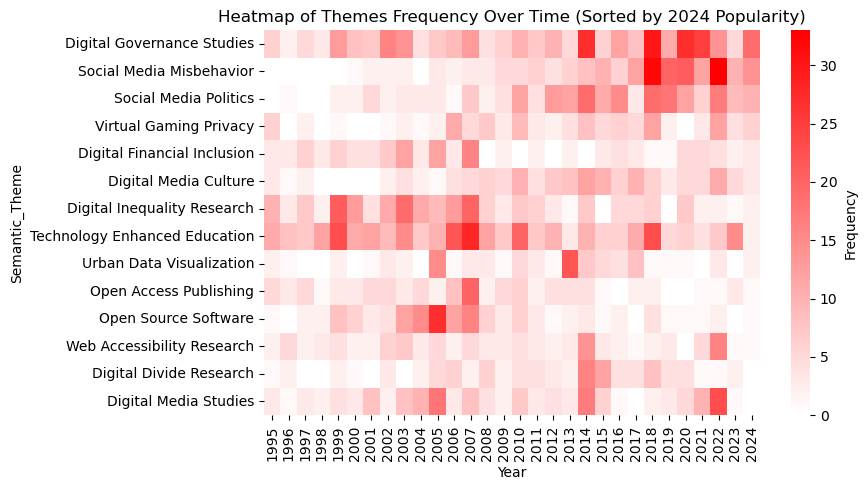

In [15]:
def visualize_topics_heatmap_year_sorted(df):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import pandas as pd
    
    # Ensure Timestamp is in datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Year'] = df['Timestamp'].dt.year

    # Pivot the data: rows as Semantic_Topic, columns as Year, aggregating Frequency by sum
    df['Frequency'] = pd.to_numeric(df['Frequency'], errors='coerce')
    pivot_df = df.pivot_table(index='Semantic_Theme', columns='Year', values='Frequency', aggfunc='sum', fill_value=0)
    
    # Identify the latest year and sort topics by frequency in that year (descending)
    latest_year = pivot_df.columns.max()
    pivot_df = pivot_df.sort_values(by=latest_year, ascending=False)
    
    # Create a custom colormap from gray (low values) to green (high values)
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gray_green", ["white", "red"])
    
    plt.figure(figsize=(8,5))
    sns.heatmap(pivot_df, cmap=cmap, cbar_kws={'label': 'Frequency'})
    plt.xlabel('Year')
    plt.ylabel('Semantic_Theme')
    plt.title(f'Heatmap of Themes Frequency Over Time (Sorted by {latest_year} Popularity)')
    plt.show()

# Usage
visualize_topics_heatmap_year_sorted(df_themes_over_time)

In [16]:
import pandas as pd
import plotly.graph_objects as go

def create_ribbon_chart(df):
    # Convert Timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Year'] = df['Timestamp'].dt.year
    
    # Pivot: rows as Timestamp, columns as topics, values as Frequency
    pivot_df = df.pivot_table(index='Year', 
                              columns='Semantic_Theme', 
                              values='Frequency', 
                              aggfunc='sum', 
                              fill_value=0)
    
    # Sort by date so ribbons flow in chronological order
    pivot_df.sort_index(inplace=True)

    return pivot_df

def visualize_ribbon_chart(pivot_df, title="Ribbon Chart of Internet Research Themes Over Time"):
    fig = go.Figure()

    # Add a trace for each topic (column in pivot_df)
    for topic in pivot_df.columns:
        fig.add_trace(go.Scatter(
            x = pivot_df.index,
            y = pivot_df[topic],
            stackgroup='one',  # This is what makes it a stacked area
            name=topic,
            mode='lines',      # or 'none' if we don't want a boundary line
            line=dict(width=0.5),
            hoverinfo='x+y+name'
        ))

    # Customize layout
    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis_title="Frequency",
        legend_title="Theme",
        hovermode="x unified"
    )

    fig.show()

# Usage:
pivot_df = create_ribbon_chart(df_themes_over_time)
visualize_ribbon_chart(pivot_df)

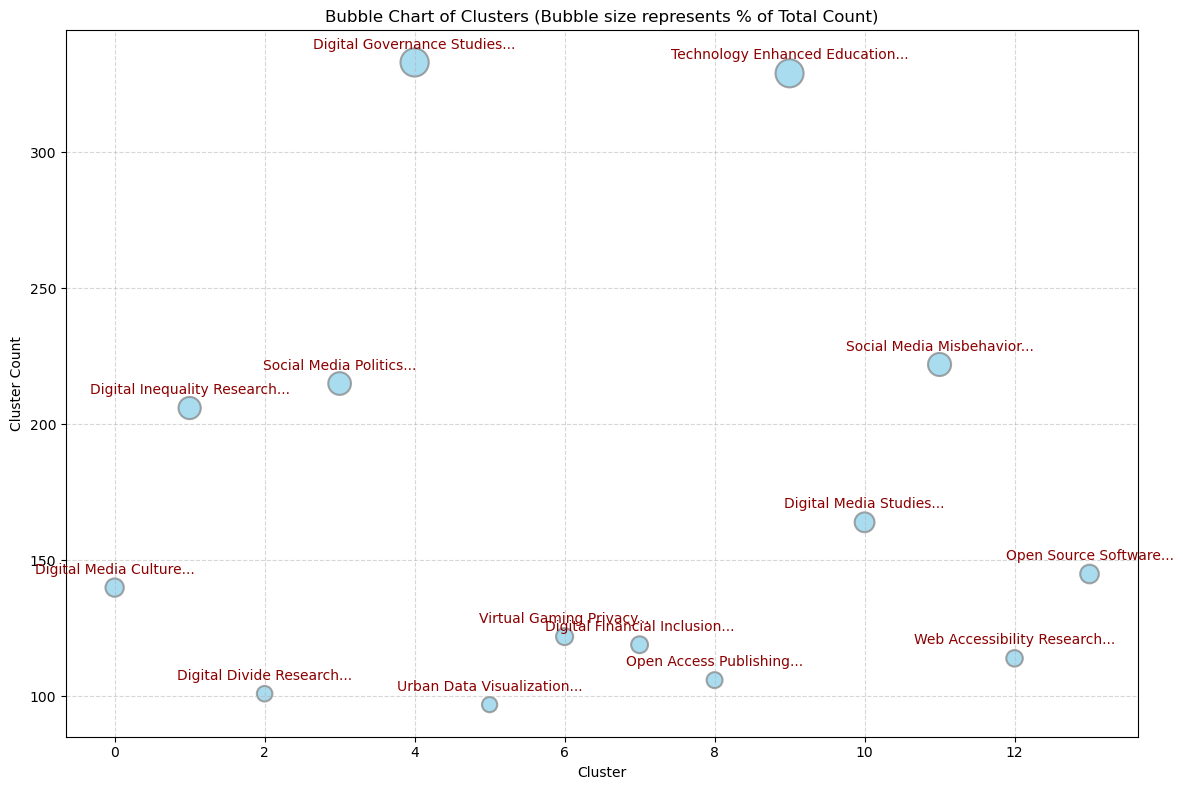

In [17]:
# Create a bubble chart for theme popularity over time
import matplotlib.pyplot as plt

theme_time_evolution = df_themes_over_time
bubble_size_factor = 30

# Create the bubble chart:
plt.figure(figsize=(12, 8))
plt.scatter(
    theme_df['Cluster'], 
    theme_df['Cluster_Count'], 
    s=theme_df['Cluster_%'] * bubble_size_factor,
    alpha=0.7,
    color='skyblue',
    edgecolors='grey',
    linewidth=1.5
)

# Anotate each bubble with the Semantic_Theme
for idx, row in theme_df.iterrows():
    plt.annotate(
        row['Semantic_Theme'][:30] + '...',  # showing first 30 characters
        (row['Cluster'], row['Cluster_Count']),
        textcoords="offset points",
        xytext=(0, 10),  # offset text 10 points above the bubble
        ha='center',
        fontsize=10,
        color='darkred'
    )

plt.xlabel('Cluster')
plt.ylabel('Cluster Count')
plt.title('Bubble Chart of Clusters (Bubble size represents % of Total Count)')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()